# ensemble

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm.auto import tqdm

In [2]:
# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [3]:
# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    if not isinstance(rle, str):
        return np.zeros(height * width, dtype=np.uint8).reshape(height, width)
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

In [4]:
classes_name = ['finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5','finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10','finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15','finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium', 'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate', 'Triquetrum', 'Pisiform', 'Radius', 'Ulna']

In [5]:
TEST_IMAGE_ROOT = '../data/test/DCM/'

pngs = {
    fname
    for root, _dirs, files in os.walk(TEST_IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}
dirs = {
    os.path.relpath(os.path.join(root, fname), start=TEST_IMAGE_ROOT)
    for root, _dirs, files in os.walk(TEST_IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

image_names = sorted(pngs)
directories = sorted(dirs, key = lambda x : x.split('//')[-1])


In [6]:
FILE_ROOT = '../result/'
OUTPUT_FILE_NAME = 'output.csv'

files = ["deeplabv3plus", "fcn", "unet3plus"]

dataframes = []
for file in files:
    dataframes.append(pd.read_csv(FILE_ROOT + f'{file}.csv'))


In [7]:
thr = len(files)/2
ensemble_result = pd.DataFrame({'image_name':[], 'class':[], 'rle':[]})
idx = 0

for image_name in tqdm(image_names, total=len(image_names)):
    for class_name in classes_name:
        rles = []
        for df in dataframes:
            rles.append(df[(df['image_name'] == image_name) & (df['class'] == class_name)]['rle'].values[0])
        
        masks = []
        for rle in rles:
            masks.append(decode_rle_to_mask(rle, 2048, 2048))

        mask = np.sum(masks, axis=0)
        mask = np.where(mask > thr, 1, 0)

        new_rle = encode_mask_to_rle(mask)
        ensemble_result.loc[idx] = [image_name, class_name, new_rle]
        idx += 1


ensemble_result.to_csv(OUTPUT_FILE_NAME, index=False)

  0%|          | 0/300 [00:00<?, ?it/s]

# visualization

In [9]:
FILE_ROOT = '../result/'
files = ["deeplabv3plus", "fcn", "unet3plus", "output"]

dataframes = []
for file in files:
    dataframes.append(pd.read_csv(FILE_ROOT + f'{file}.csv'))

In [10]:
# define colors
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# utility function
# this does not care overlap
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

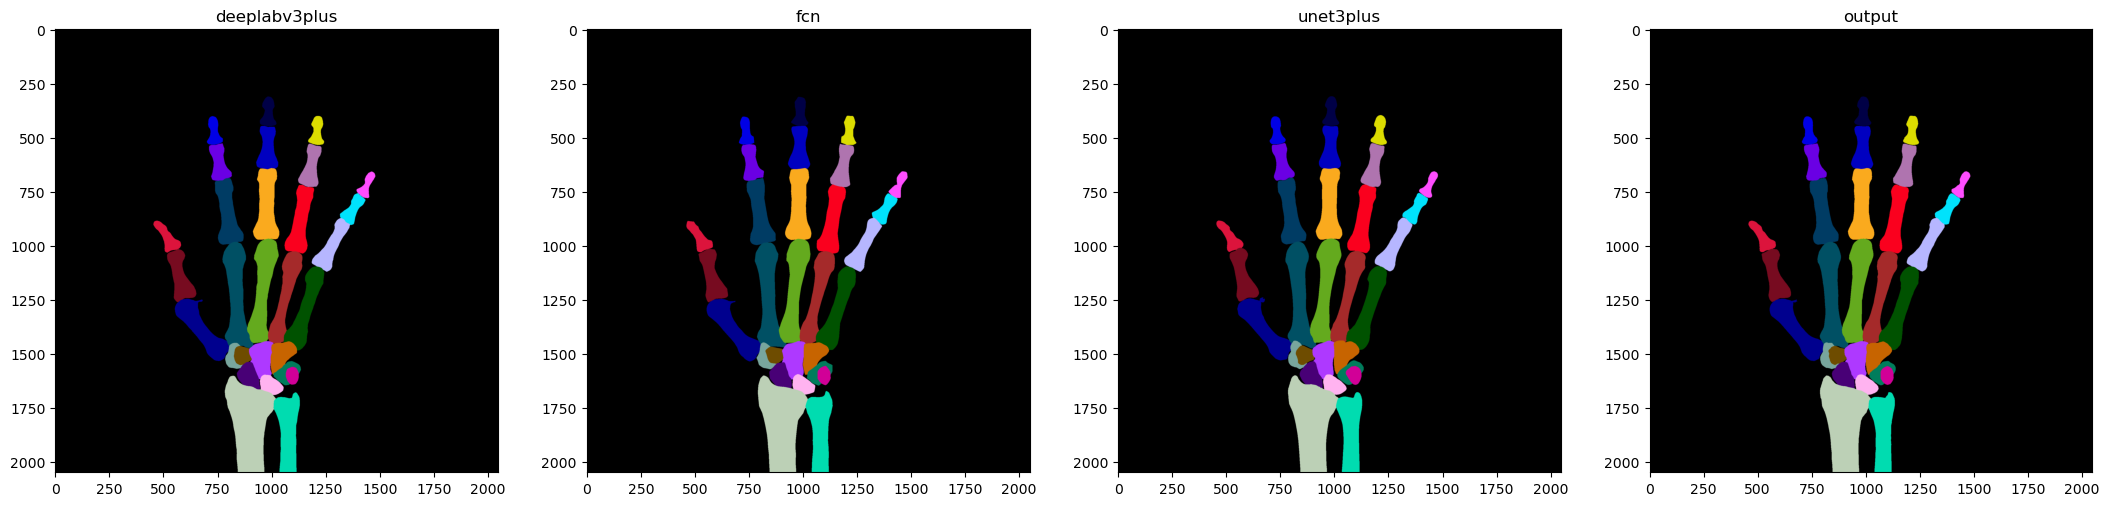

In [11]:
import cv2 
import matplotlib.pyplot as plt

IMAGE_IDX = 0
image_name = image_names[IMAGE_IDX]

image = cv2.imread(os.path.join(TEST_IMAGE_ROOT, directories[0]))

plt.figure(figsize=(40,120))

file_len = len(files)
plt.subplot(1, file_len+2, 1)
plt.title("image")
plt.imshow(image)

for i in range(file_len):
    plt.subplot(1, file_len+2, 1 + i)

    df = dataframes[i]
    masks = []
    for class_name in classes_name:
        rle = df[(df['image_name'] == image_name) & (df['class'] == class_name)]['rle'].values[0]
        masks.append(decode_rle_to_mask(rle, 2048, 2048)) 

    mask = np.stack(masks, 0)
    plt.imshow(label2rgb(mask), cmap='gray')
    plt.title(files[i])